# Combiom. Statistical analysis, cross validation and plotting

Statistical analysis of results using Pandas and Scikit-Learn, cross-validation, and plotting.

# Importing modules

In [1]:
import IPython.display as ipy
import pandas as pd
import csv
import numpy as np
import itertools
import xlsxwriter
import numexpr as ne

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import scipy as sc

import sklearn.linear_model as sk_lm
import sklearn.preprocessing as sk_pr
import sklearn.kernel_ridge as sk_kr
import sklearn.model_selection as sk_cv

import seaborn as sns
import string as st

### Seaborn style

In [2]:
colors = ["#332288", "#117733", "#AA4499", "#AA4499"]
sns.set(style='whitegrid', context="talk", palette=sns.color_palette(colors),
        font="Noto Sans", font_scale=1.1,
        rc={'axes.linewidth': 1.5,
            'axes.labelsize': 16,
            'axes.labelweight': 'bold',
            'axes.edgecolor': '0.25',
            'axes.grid': False,
            'font.family': 'sans-serif',
            'font.sans-serif': 'Roboto Condensed',
            'ytick.major.size': 6,
            'xtick.major.size': 6,
            'ytick.major.width': 1.5,
            'xtick.major.width': 1.5,
            'ytick.color': '0.25',
            'xtick.color': '0.25'
})

# 1 Biochemical markers

## 1.1 Importing Data

In [3]:
# read pickle to pandas DataFrame
bio_df = pd.read_pickle('biochem_db.pickle')

# biomarkers
bio_df['Biomarker'].count()

917

## 1.2 Importing and Preprocessing Raw Data

In [7]:
# Parameter names
bio_csv_names = csv.reader(open('./BiochemData/parameters-names.csv'), delimiter=';')
bio_parameter_names = np.array(list(bio_csv_names)).flatten()

# Setting shape of data array
bio_volunteers = 10
bio_parameters = 11
bio_points = 8

# Initializing data array with zeros
bio_data = np.zeros(shape=(bio_volunteers, bio_parameters, bio_points))

# Timepoints at which each biochemical parameter was measured (in hours after experiment)
# Null stands for "before experiment", 1 - in an hour after experiment, so on...
bio_timepoints = np.array([0, 1, 1*24, 2*24, 3*24, 5*24, 7*24, 9*24])

# Reading numeric data from csv-files
# Each file has a shape of N x M
#     where N is the number of parameters and M is the number of timepoints at which they were measured
for i in np.arange(bio_volunteers):
    bio_csv_file = csv.reader(open('./BiochemData/%d.csv' % i), delimiter=';')
    bio_data[i, 0: bio_parameters + 1, 0: bio_points + 1] = np.array(list(bio_csv_file), np.float64)

In [8]:
# Target markers
bio_target_names = np.array(['Creatinekinase', 'AST', 'Myoglobin',
                    'Creatinekinase / AST', 'Creatinekinase / Myoglobin',
                    'Creatinekinase / Albumin', 'Myoglobin / Albumin'])

# Reading data for creatine kinase
bio_csv_ck = csv.reader(open('./BiochemData/creatine-kinase.csv'), delimiter=';')
bio_ckdata = np.array(list(bio_csv_ck), np.float64)

# Reading data for aspartate transferase
bio_csv_ast = csv.reader(open('./BiochemData/aspartate-transferase.csv'), delimiter=';')
bio_astdata = np.array(list(bio_csv_ast), np.float64)

# Reading data for myoglobin
bio_csv_mg = csv.reader(open('./BiochemData/myoglobin.csv'), delimiter=';')
bio_mgdata = np.array(list(bio_csv_mg), np.float64)
bio_mgdata[bio_mgdata == 0] = np.nan

imp = sk_pr.Imputer(missing_values='NaN', strategy='mean')
bio_mgdata = imp.fit_transform(bio_mgdata)

# Reading data for albumin
bio_csv_alb = csv.reader(open('./BiochemData/albumin.csv'), delimiter=';')
bio_albdata = np.array(list(bio_csv_alb), np.float64)
bio_albdata[bio_albdata == 0] = np.nan

# Processing creatinekinase and AST data
# Making an array of maximum values and taking a LOG10 element-wisely
bio_ckmax = np.log10([np.max(z) for z in bio_ckdata])
bio_astmax = np.log10([np.max(z) for z in bio_astdata])
bio_mgmax = np.log10([np.max(z) for z in bio_mgdata])

bio_alb = np.log10(bio_albdata[np.arange(bio_albdata.shape[0]), [np.argmax(z) for z in bio_ckdata]])

bio_ckmg = bio_ckmax / np.log10(bio_mgdata[np.arange(bio_mgdata.shape[0]), [np.argmax(z) for z in bio_ckdata]])
bio_ckast = bio_ckmax / np.log10(bio_astdata[np.arange(bio_astdata.shape[0]), [np.argmax(z) for z in bio_ckdata]])
bio_ckalb = bio_ckmax / bio_alb
bio_mgalb = bio_mgmax / bio_alb

bio_target_data = np.vstack((bio_ckmax, bio_astmax, bio_mgmax, bio_ckmg, bio_ckast, bio_ckalb, bio_mgalb))

# Making an array of 1-hour measures
bio_data1h = bio_data[:,:,1].T

## 1.3 Results

### 1.3.1 Markers with highest correlations

In [9]:
# process DataFrame
z = bio_df.sort_values(by='Kernel Ridge Score', ascending=False)\
          .head(10)\
          .reset_index(drop=True)\
          [['Biomarker', 'Target marker', 'Kernel Ridge Score', 'Ridge Score', 'Theil-Sen Score', 'Type', 'MID']]

ipy.display(z)

# initialize ExcelWriter
writer = pd.ExcelWriter('Results/combinatorial_biochemical_markers_highest_corrs.xlsx', engine='xlsxwriter')

# convert the dataframe to an XlsxWriter Excel object
z.to_excel(writer, sheet_name='Markers')

workbook = writer.book
worksheet = writer.sheets['Markers']
worksheet.conditional_format('D2:D11', {'type': '2_color_scale',
                                        'min_color': '#FFFAD2',
                                        'max_color': '#ED875E'})
worksheet.conditional_format('E2:E11', {'type': '2_color_scale',
                                        'min_color': '#E6F5FE',
                                        'max_color': '#77B7E5'})
worksheet.conditional_format('F2:F11', {'type': '2_color_scale',
                                        'min_color': '#CAE0AB',
                                        'max_color': '#4EB265'})
# Save an Excel file
writer.save()

,Biomarker,Target marker,Kernel Ridge Score,Ridge Score,Theil-Sen Score,Type,MID
0,Urea/Phosphate/MCFA,Creatinekinase / AST,0.945346,0.775248,0.594007,a/b/c,"2, 5, 10"
1,Glucose/Cholesterol/MCFA,Creatinekinase / AST,0.938394,0.773713,0.882559,a/b/c,"8, 1, 10"
2,Urea*Chloride/Phosphate/MCFA,Creatinekinase / AST,0.934558,0.749022,0.598690,a*b/c/d,"2, 6, 5, 10"
3,Lactate*Bilirubin/Phosphate/MCFA,Creatinekinase,0.923575,0.367600,3.416179,a*b/c/d,"3, 7, 5, 10"
4,Chloride*Glucose/Cholesterol/MCFA,Creatinekinase / AST,0.923375,0.759986,0.937097,a*b/c/d,"6, 8, 1, 10"
5,Creatinine*Glucose/Phosphate/MCFA,Creatinekinase / AST,0.922830,0.776801,0.471683,a*b/c/d,"0, 8, 5, 10"
6,Lactate*Bilirubin/Phosphate/MCFA,Creatinekinase / Albumin,0.917624,0.354694,3.083840,a*b/c/d,"3, 7, 5, 10"
7,Creatinine/Cholesterol/MCFA,Creatinekinase / AST,0.915855,0.803509,0.671390,a/b/c,"0, 1, 10"
8,Glucose*Uric acid/Lactate/MCFA,Creatinekinase / AST,0.915062,0.587761,0.469122,a*b/c/d,"8, 9, 3, 10"
9,Uric acid*MCFA/Urea/Phosphate,Creatinekinase / Albumin,0.914331,0.530794,2.659062,a*b/c/d,"9, 10, 2, 5"


### 1.3.2 Grouping markers by type

In [10]:
# Showing top 5 of each type
for i, g in enumerate(bio_df.groupby('Type').groups.keys()):
    ipy.display(ipy.Markdown('### Combinatorial biomarkers of type _' + g + '_'))
    ipy.display(bio_df.groupby('Type')\
                .get_group(g)\
                .sort_values(by='Kernel Ridge Score', ascending=False)\
                .head(5)\
                .reset_index(drop=True))

### Combinatorial biomarkers of type _a/b/c_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,Urea/Phosphate/MCFA,Creatinekinase / AST,Urea,Phosphate,MCFA,NaN,0.594007,0.775248,0.945346,"2, 5, 10",3,a/b/c
1,Glucose/Cholesterol/MCFA,Creatinekinase / AST,Glucose,Cholesterol,MCFA,NaN,0.882559,0.773713,0.938394,"8, 1, 10",3,a/b/c
2,Creatinine/Cholesterol/MCFA,Creatinekinase / AST,Creatinine,Cholesterol,MCFA,NaN,0.671390,0.803509,0.915855,"0, 1, 10",3,a/b/c
3,Uric acid/Lactate/MCFA,Creatinekinase / AST,Uric acid,Lactate,MCFA,NaN,0.403813,0.656535,0.900626,"9, 3, 10",3,a/b/c
4,Cholesterol/Phosphate/Chloride,Creatinekinase / Albumin,Cholesterol,Phosphate,Chloride,NaN,1.323900,0.748628,0.893998,"1, 5, 6",5,a/b/c


### Combinatorial biomarkers of type _a*b/c_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,Creatinine*Cholesterol/Phosphate,Myoglobin,Creatinine,Cholesterol,Phosphate,NaN,1.052531,0.753447,0.835570,"0, 1, 5",2,a*b/c
1,Creatinine*Cholesterol/Phosphate,Myoglobin / Albumin,Creatinine,Cholesterol,Phosphate,NaN,1.026547,0.747715,0.828258,"0, 1, 5",6,a*b/c
2,Creatinine*Lactate/Phosphate,Creatinekinase,Creatinine,Lactate,Phosphate,NaN,1.130636,0.584689,0.798721,"0, 3, 5",0,a*b/c
3,Creatinine*Lactate/Phosphate,Creatinekinase / Albumin,Creatinine,Lactate,Phosphate,NaN,1.084492,0.572713,0.791881,"0, 3, 5",5,a*b/c
4,Cholesterol*TAG/Glucose,Creatinekinase,Cholesterol,TAG,Glucose,NaN,0.960659,0.050938,0.772266,"1, 4, 8",0,a*b/c


### Combinatorial biomarkers of type _a/b_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,Phosphate/Cholesterol,Creatinekinase / Albumin,Phosphate,Cholesterol,NaN,NaN,0.941322,0.767557,0.879388,"5, 1",5,a/b
1,Phosphate/Cholesterol,Creatinekinase,Phosphate,Cholesterol,NaN,NaN,0.964244,0.771610,0.877854,"5, 1",0,a/b
2,Cholesterol/Phosphate,Creatinekinase / Albumin,Cholesterol,Phosphate,NaN,NaN,1.217633,0.720137,0.877565,"1, 5",5,a/b
3,Cholesterol/Phosphate,Creatinekinase,Cholesterol,Phosphate,NaN,NaN,1.232067,0.727198,0.876488,"1, 5",0,a/b
4,Lactate/Phosphate,AST,Lactate,Phosphate,NaN,NaN,1.307867,0.592371,0.828406,"3, 5",1,a/b


### Combinatorial biomarkers of type _1/a_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,1/Uric acid,Myoglobin / Albumin,Uric acid,NaN,NaN,NaN,1.613496,0.402234,0.669841,9,6,1/a
1,1/Uric acid,Myoglobin,Uric acid,NaN,NaN,NaN,1.868534,0.395287,0.663890,9,2,1/a
2,1/Chloride,Myoglobin / Albumin,Chloride,NaN,NaN,NaN,1.096928,0.048249,0.342915,6,6,1/a
3,1/Chloride,Myoglobin,Chloride,NaN,NaN,NaN,1.095258,0.046104,0.327674,6,2,1/a


### Combinatorial biomarkers of type _a*b/c/d_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,Urea*Chloride/Phosphate/MCFA,Creatinekinase / AST,Urea,Chloride,Phosphate,MCFA,0.598690,0.749022,0.934558,"2, 6, 5, 10",3,a*b/c/d
1,Lactate*Bilirubin/Phosphate/MCFA,Creatinekinase,Lactate,Bilirubin,Phosphate,MCFA,3.416179,0.367600,0.923575,"3, 7, 5, 10",0,a*b/c/d
2,Chloride*Glucose/Cholesterol/MCFA,Creatinekinase / AST,Chloride,Glucose,Cholesterol,MCFA,0.937097,0.759986,0.923375,"6, 8, 1, 10",3,a*b/c/d
3,Creatinine*Glucose/Phosphate/MCFA,Creatinekinase / AST,Creatinine,Glucose,Phosphate,MCFA,0.471683,0.776801,0.922830,"0, 8, 5, 10",3,a*b/c/d
4,Lactate*Bilirubin/Phosphate/MCFA,Creatinekinase / Albumin,Lactate,Bilirubin,Phosphate,MCFA,3.083840,0.354694,0.917624,"3, 7, 5, 10",5,a*b/c/d


### Combinatorial biomarkers of type _a_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,Uric acid,Myoglobin / Albumin,Uric acid,NaN,NaN,NaN,1.176881,0.517416,0.683235,9,6,a
1,Uric acid,Myoglobin,Uric acid,NaN,NaN,NaN,1.259103,0.509880,0.675729,9,2,a
2,Chloride,Myoglobin,Chloride,NaN,NaN,NaN,1.110306,0.048832,0.332873,6,2,a


### 1.3.2 Combinatorial Markers Grouped by Target Marker

In [11]:
# Showing top 5 of each target marker
for i, g in enumerate(bio_df.groupby('Target marker').groups.keys()):
    ipy.display(ipy.Markdown('### Combinatorial biomarkers correlation with _' + g + '_'))
    ipy.display(bio_df.groupby('Target marker')\
                .get_group(g)\
                .sort_values(by='Kernel Ridge Score', ascending=False)\
                .head(5)\
                .reset_index(drop=True))

### Combinatorial biomarkers correlation with _AST_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,Uric acid*MCFA/Urea/Glucose,AST,Uric acid,MCFA,Urea,Glucose,1.225463,0.682314,0.903691,"9, 10, 2, 8",1,a*b/c/d
1,Creatinine*Lactate/Phosphate/Glucose,AST,Creatinine,Lactate,Phosphate,Glucose,0.769675,0.603001,0.903532,"0, 3, 5, 8",1,a*b/c/d
2,Urea*Glucose/Uric acid/MCFA,AST,Urea,Glucose,Uric acid,MCFA,0.822443,0.846807,0.899980,"2, 8, 9, 10",1,a*b/c/d
3,Lactate*Chloride/Phosphate/Glucose,AST,Lactate,Chloride,Phosphate,Glucose,0.635290,0.671867,0.896244,"3, 6, 5, 8",1,a*b/c/d
4,Lactate/Phosphate/Glucose,AST,Lactate,Phosphate,Glucose,NaN,0.684752,0.670776,0.892386,"3, 5, 8",1,a/b/c


### Combinatorial biomarkers correlation with _Creatinekinase / AST_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,Urea/Phosphate/MCFA,Creatinekinase / AST,Urea,Phosphate,MCFA,NaN,0.594007,0.775248,0.945346,"2, 5, 10",3,a/b/c
1,Glucose/Cholesterol/MCFA,Creatinekinase / AST,Glucose,Cholesterol,MCFA,NaN,0.882559,0.773713,0.938394,"8, 1, 10",3,a/b/c
2,Urea*Chloride/Phosphate/MCFA,Creatinekinase / AST,Urea,Chloride,Phosphate,MCFA,0.598690,0.749022,0.934558,"2, 6, 5, 10",3,a*b/c/d
3,Chloride*Glucose/Cholesterol/MCFA,Creatinekinase / AST,Chloride,Glucose,Cholesterol,MCFA,0.937097,0.759986,0.923375,"6, 8, 1, 10",3,a*b/c/d
4,Creatinine*Glucose/Phosphate/MCFA,Creatinekinase / AST,Creatinine,Glucose,Phosphate,MCFA,0.471683,0.776801,0.922830,"0, 8, 5, 10",3,a*b/c/d


### Combinatorial biomarkers correlation with _Creatinekinase / Myoglobin_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,Urea*Phosphate/Lactate/Bilirubin,Creatinekinase / Myoglobin,Urea,Phosphate,Lactate,Bilirubin,0.874465,0.144337,0.785268,"2, 5, 3, 7",4,a*b/c/d
1,Uric acid*MCFA/Urea/Lactate,Creatinekinase / Myoglobin,Uric acid,MCFA,Urea,Lactate,7.029963,0.000877,0.754901,"9, 10, 2, 3",4,a*b/c/d
2,Creatinine*Phosphate/Lactate/Bilirubin,Creatinekinase / Myoglobin,Creatinine,Phosphate,Lactate,Bilirubin,0.907857,0.142666,0.723210,"0, 5, 3, 7",4,a*b/c/d
3,Cholesterol*Phosphate/Lactate/Bilirubin,Creatinekinase / Myoglobin,Cholesterol,Phosphate,Lactate,Bilirubin,0.969868,0.094256,0.720505,"1, 5, 3, 7",4,a*b/c/d
4,Cholesterol*Urea/Lactate/Bilirubin,Creatinekinase / Myoglobin,Cholesterol,Urea,Lactate,Bilirubin,1.204231,0.168607,0.711603,"1, 2, 3, 7",4,a*b/c/d


### Combinatorial biomarkers correlation with _Myoglobin / Albumin_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,Creatinine*Cholesterol/Phosphate/Chloride,Myoglobin / Albumin,Creatinine,Cholesterol,Phosphate,Chloride,0.929592,0.777935,0.869824,"0, 1, 5, 6",6,a*b/c/d
1,Phosphate*Chloride/Creatinine/Cholesterol,Myoglobin / Albumin,Phosphate,Chloride,Creatinine,Cholesterol,0.950528,0.810361,0.857362,"5, 6, 0, 1",6,a*b/c/d
2,TAG*Phosphate/Glucose/MCFA,Myoglobin / Albumin,TAG,Phosphate,Glucose,MCFA,0.287904,0.095154,0.853686,"4, 5, 8, 10",6,a*b/c/d
3,Urea*Glucose/Lactate/MCFA,Myoglobin / Albumin,Urea,Glucose,Lactate,MCFA,0.926484,0.119592,0.834801,"2, 8, 3, 10",6,a*b/c/d
4,Urea*Glucose/Uric acid/MCFA,Myoglobin / Albumin,Urea,Glucose,Uric acid,MCFA,1.077099,0.412534,0.833244,"2, 8, 9, 10",6,a*b/c/d


### Combinatorial biomarkers correlation with _Creatinekinase / Albumin_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,Lactate*Bilirubin/Phosphate/MCFA,Creatinekinase / Albumin,Lactate,Bilirubin,Phosphate,MCFA,3.083840,0.354694,0.917624,"3, 7, 5, 10",5,a*b/c/d
1,Uric acid*MCFA/Urea/Phosphate,Creatinekinase / Albumin,Uric acid,MCFA,Urea,Phosphate,2.659062,0.530794,0.914331,"9, 10, 2, 5",5,a*b/c/d
2,Urea*Phosphate/Uric acid/MCFA,Creatinekinase / Albumin,Urea,Phosphate,Uric acid,MCFA,0.860611,0.816797,0.899992,"2, 5, 9, 10",5,a*b/c/d
3,Cholesterol/Phosphate/Chloride,Creatinekinase / Albumin,Cholesterol,Phosphate,Chloride,NaN,1.323900,0.748628,0.893998,"1, 5, 6",5,a/b/c
4,Uric acid*MCFA/Urea/Glucose,Creatinekinase / Albumin,Uric acid,MCFA,Urea,Glucose,1.971728,0.584041,0.892750,"9, 10, 2, 8",5,a*b/c/d


### Combinatorial biomarkers correlation with _Myoglobin_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,Creatinine*Cholesterol/Phosphate/Chloride,Myoglobin,Creatinine,Cholesterol,Phosphate,Chloride,0.908153,0.780803,0.872165,"0, 1, 5, 6",2,a*b/c/d
1,Phosphate*Chloride/Creatinine/Cholesterol,Myoglobin,Phosphate,Chloride,Creatinine,Cholesterol,0.934100,0.812799,0.859951,"5, 6, 0, 1",2,a*b/c/d
2,TAG*Phosphate/Glucose/MCFA,Myoglobin,TAG,Phosphate,Glucose,MCFA,0.280133,0.089931,0.856696,"4, 5, 8, 10",2,a*b/c/d
3,Urea*Glucose/Lactate/MCFA,Myoglobin,Urea,Glucose,Lactate,MCFA,0.876140,0.112307,0.838786,"2, 8, 3, 10",2,a*b/c/d
4,Creatinine*Cholesterol/Phosphate,Myoglobin,Creatinine,Cholesterol,Phosphate,NaN,1.052531,0.753447,0.835570,"0, 1, 5",2,a*b/c


### Combinatorial biomarkers correlation with _Creatinekinase_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,Lactate*Bilirubin/Phosphate/MCFA,Creatinekinase,Lactate,Bilirubin,Phosphate,MCFA,3.416179,0.367600,0.923575,"3, 7, 5, 10",0,a*b/c/d
1,Uric acid*MCFA/Urea/Phosphate,Creatinekinase,Uric acid,MCFA,Urea,Phosphate,2.062798,0.539588,0.904120,"9, 10, 2, 5",0,a*b/c/d
2,Uric acid*MCFA/Urea/Glucose,Creatinekinase,Uric acid,MCFA,Urea,Glucose,1.875996,0.594636,0.898579,"9, 10, 2, 8",0,a*b/c/d
3,Urea*Phosphate/Uric acid/MCFA,Creatinekinase,Urea,Phosphate,Uric acid,MCFA,0.888139,0.801526,0.891501,"2, 5, 9, 10",0,a*b/c/d
4,Cholesterol/Phosphate/Chloride,Creatinekinase,Cholesterol,Phosphate,Chloride,NaN,1.122834,0.754162,0.889026,"1, 5, 6",0,a/b/c


## 1.4 Statistics and Analysis

### 1.4.1 Correlations Between Combinatorial Markers and Target Markers

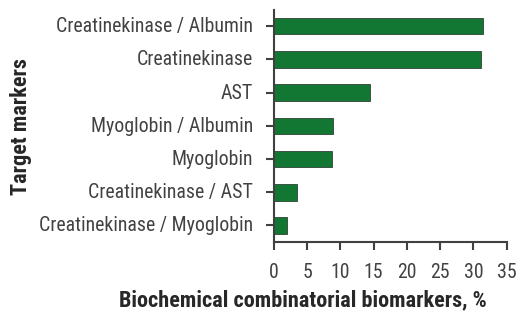

In [12]:
g = bio_df[['Target marker']].stack()\
                             .value_counts()\
                             .sort_values(ascending=True)\
                             .apply(lambda x: np.around(x / bio_df['Biomarker'].count() * 100, 1))\
                             .plot(kind='barh', figsize=(3,3), color='#117733')

g.set_ylabel('Target markers')
g.set_xlabel('Biochemical combinatorial biomarkers, %', ha='center', position=(0.125, 0))

sns.despine()

In [13]:
bio_df[['Target marker']].stack()\
                         .value_counts()\
                         .sort_values(ascending=False)\
                         .apply(lambda x: np.around(x / bio_df['Biomarker'].count() * 100, 1))\

Creatinekinase / Albumin      31.4
Creatinekinase                31.1
AST                           14.4
Myoglobin / Albumin            8.9
Myoglobin                      8.7
Creatinekinase / AST           3.5
Creatinekinase / Myoglobin     2.0
dtype: float64

### 1.4.2 Occurence of Individual Markers in Combinatorial Markers

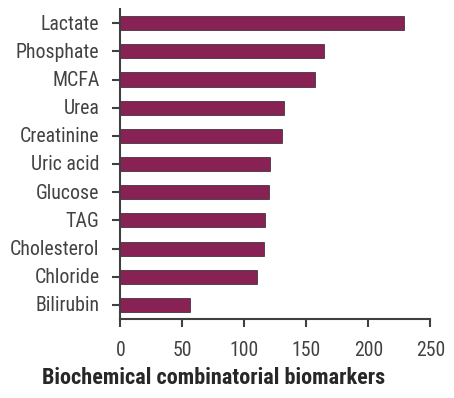

In [14]:
unique_markers = bio_df.drop_duplicates(subset='Biomarker').reset_index(drop=True)

g = unique_markers[['Marker 1', 'Marker 2', 'Marker 3', 'Marker 4']]\
            .stack()\
            .value_counts()\
            .sort_values(ascending=True)\
            .plot(kind='barh', figsize=(4,4), color='#882255')

g.set_xlabel('Biochemical combinatorial biomarkers', ha='center', position=(0.30, 0))
sns.despine()

In [15]:
# Percentage of single markers in combinatorial biomarkers
unique_markers = bio_df.drop_duplicates(subset='Biomarker').reset_index(drop=True)
g = unique_markers[['Marker 1', 'Marker 2', 'Marker 3', 'Marker 4']]\
            .stack()\
            .value_counts()\
            .apply(lambda x: str(np.around(x / unique_markers['MID'].count() * 100, 1)) + '%')\
            .sort_values(ascending=False)
g

Lactate        58.3%
Phosphate      41.7%
MCFA           39.9%
Urea           33.6%
Creatinine     33.1%
Uric acid      30.8%
Glucose        30.5%
TAG            29.8%
Cholesterol    29.5%
Chloride       28.0%
Bilirubin      14.2%
dtype: object

### 1.4.3 Biochemical biomarkers and target markers: joint sets

In [16]:
q = bio_df.groupby(('Biomarker'))\
          .agg({'Target marker': 'count', 'Kernel Ridge Score': 'mean', 'Theil-Sen Score': 'mean', 'Ridge Score': 'mean'})\
          .sort_values(['Target marker', 'Kernel Ridge Score'], ascending=False)

ipy.display(ipy.Markdown('#### Markers strongly correlated with three or more targets'),
            len(q[q['Target marker'] >= 3].index))

ipy.display(ipy.Markdown('#### Unique combinatorial markers'),
            len(q.index),
            ipy.HTML(
                        q.head(10)\
                          [['Target marker', 'Kernel Ridge Score', 'Ridge Score', 'Theil-Sen Score']]
                          .reset_index()\
                          .to_html()
))

#### Markers strongly correlated with three or more targets

148

#### Unique combinatorial markers

393

,Biomarker,Target marker,Kernel Ridge Score,Ridge Score,Theil-Sen Score
0,Urea*Phosphate/Lactate/Bilirubin,6,0.792913,0.259419,1.669345
1,Creatinine*Urea/Lactate/Bilirubin,6,0.678736,0.246219,1.534484
2,Cholesterol*Urea/Lactate/Bilirubin,6,0.670188,0.230477,1.219462
3,Urea*Glucose/Uric acid/MCFA,5,0.862664,0.653679,0.918536
4,Creatinine*Phosphate/Lactate/Uric acid,5,0.810566,0.321485,1.897554
5,Uric acid*MCFA/Urea/Glucose,5,0.810290,0.562593,1.588352
6,Urea*Phosphate/Lactate/MCFA,5,0.807465,0.381844,1.436135
7,Phosphate/Lactate/Uric acid,5,0.799591,0.346011,1.765379
8,Phosphate*Chloride/Lactate/Uric acid,5,0.795285,0.356422,1.635243
9,Creatinine*Urea/Lactate/MCFA,5,0.791425,0.350083,1.057615


In [17]:
writer = pd.ExcelWriter('Results/combinatorial_biochemical_markers_top_10_joint.xlsx', engine='xlsxwriter')

j = bio_df.groupby(('Biomarker'))\
          .agg({'Target marker': 'count', 'Kernel Ridge Score': 'mean', 'Theil-Sen Score': 'mean', 'Ridge Score': 'mean'})\
          .sort_values(['Target marker', 'Kernel Ridge Score'], ascending=False)\
          .head(10)\
          [['Target marker', 'Kernel Ridge Score', 'Ridge Score', 'Theil-Sen Score']]\
          .reset_index()
ipy.display(j)

j.to_excel(writer, sheet_name='Markers')
writer.save()

,Biomarker,Target marker,Kernel Ridge Score,Ridge Score,Theil-Sen Score
0,Urea*Phosphate/Lactate/Bilirubin,6,0.792913,0.259419,1.669345
1,Creatinine*Urea/Lactate/Bilirubin,6,0.678736,0.246219,1.534484
2,Cholesterol*Urea/Lactate/Bilirubin,6,0.670188,0.230477,1.219462
3,Urea*Glucose/Uric acid/MCFA,5,0.862664,0.653679,0.918536
4,Creatinine*Phosphate/Lactate/Uric acid,5,0.810566,0.321485,1.897554
5,Uric acid*MCFA/Urea/Glucose,5,0.810290,0.562593,1.588352
6,Urea*Phosphate/Lactate/MCFA,5,0.807465,0.381844,1.436135
7,Phosphate/Lactate/Uric acid,5,0.799591,0.346011,1.765379
8,Phosphate*Chloride/Lactate/Uric acid,5,0.795285,0.356422,1.635243
9,Creatinine*Urea/Lactate/MCFA,5,0.791425,0.350083,1.057615


In [18]:
bio_df.groupby('Biomarker')[bio_df.columns]\
      .agg(['count', 'mean', 'std'])\
      .sort_values([('Theil-Sen Score', 'count')], ascending=False)

Theil-Sen Score                      \
                                                   count      mean       std   
Biomarker                                                                      
Creatinine*Urea/Lactate/Bilirubin                      6  1.534484  0.449780   
Cholesterol*Urea/Lactate/Bilirubin                     6  1.219462  0.184275   
Urea*Phosphate/Lactate/Bilirubin                       6  1.669345  0.536198   
Phosphate*Chloride/Lactate/Uric acid                   5  1.635243  0.672817   
Urea*Phosphate/Lactate/MCFA                            5  1.436135  0.260894   
Creatinine*Phosphate/Lactate/Uric acid                 5  1.897554  0.560723   
Creatinine*Phosphate/Lactate/Bilirubin                 5  1.042296  0.174278   
Lactate*Bilirubin/Urea/Phosphate                       5  1.162624  0.172400   
Phosphate/Lactate/Uric acid                            5  1.765379  0.495194   
TAG*MCFA/Lactate/Uric acid                             5  5.778209  3.015822   
Urea*Chloride/Lactate/Bilirubin                        5  1.146329  0.129168   
Urea*Glucose/Lactate/Bilirubin                         5  1.654888  0.511182   
Urea*Glucose/Uric acid/MCFA                            5  0.918536  0.114973   
Creatinine*Urea/Lactate/MCFA                           5  1.057615  0.165808   
Uric acid*MCFA/Urea/Glucose                            5  1.588352  0.379235   
Urea/Lactate/Bilirubin                                 5  1.203405  0.168229   
Urea*TAG/Lactate/MCFA                                  5  1.399419  0.414886   
Lactate*MCFA/Chloride/Glucose                          4  1.073115  0.300242   
Phosphate*Glucose/Lactate/Uric acid                    4  1.749510  0.436661   
Cholesterol*Phosphate/Lactate/Uric acid                4  1.622381  0.789263   
TAG*Glucose/Lactate/MCFA                               4  1.449393  0.059203   
Lactate*Bilirubin/Creatinine/Urea                      4  1.741631  0.629398   
Phosphate/Lactate/Chloride                             4  1.196794  0.291553   
Cholesterol*TAG/Lactate/MCFA                           4  1.087913  0.078522   
Phosphate/Cholesterol/Chloride                         4  0.923439  0.034196   
Phosphate*Uric acid/Lactate/MCFA                       4  1.155440  0.034370   
Phosphate*MCFA/Lactate/Bilirubin                       4  1.194126  0.021087   
Phosphate*Glucose/Lactate/Chloride                     4  1.935555  0.541069   
Phosphate*Glucose/Lactate/MCFA                         4  1.128203  0.121858   
TAG*Phosphate/Lactate/MCFA                             4  1.156442  0.044511   
...                                                  ...       ...       ...   
Lactate*MCFA/Creatinine/Cholesterol                    1  0.938470       NaN   
TAG*Glucose/Cholesterol/Lactate                        1  0.863647       NaN   
Urea*Lactate/TAG/Chloride                              1  1.048885       NaN   
TAG*Glucose/Creatinine/MCFA                            1  0.959963       NaN   
Urea*Lactate/TAG                                       1  1.169732       NaN   
Lactate*Bilirubin/Creatinine/Cholesterol               1  1.260703       NaN   
Creatinine*Phosphate/Cholesterol/MCFA                  1  0.857796       NaN   
Urea*Lactate/Glucose                                   1  0.884308       NaN   
Urea*Lactate/Creatinine/Phosphate                      1  0.892593       NaN   
Urea*Lactate/Cholesterol/TAG                           1  1.169094       NaN   
Urea*Lactate/Cholesterol/Phosphate                     1  0.890364       NaN   
Lactate*Bilirubin/Creatinine/TAG                       1  2.112037       NaN   
Cholesterol*Glucose/Creatinine/Phosphate               1  0.922545       NaN   
Cholesterol*Glucose/Lactate/Bilirubin                  1  0.986301       NaN   
Creatinine*MCFA/Urea/TAG                               1  1.038619       NaN   
Creatinine*MCFA/Urea/Lactate                           1  0.944752       NaN   
Urea*Chloride/Phosphate/MCFA             

## 1.4 Cross-Validation

In [19]:
def cv_iter(num):

    bio_cv_dict = {'Biomarker': [], 'Target marker': [], 'Type': [],
                   'MAPE': [], 'MAD': [], 'MSE': [], 'RMSE': []}

    for btn, i in itertools.product(bio_target_names, np.arange(num)):

        params = bio_df.groupby('Target marker')\
                   .get_group(btn)\
                   .sort_values(by='Kernel Ridge Score', ascending=False)\
                   .reset_index(drop=True)\
                   .loc[i]['MID']\
                   .split(', ')
        group = bio_df.groupby('Target marker')\
                   .get_group(btn)\
                   .sort_values(by='Kernel Ridge Score', ascending=False)\
                   .reset_index(drop=True)\
                   .loc[i]['Type']

        name = bio_df.groupby('Target marker')\
                   .get_group(btn)\
                   .sort_values(by='Kernel Ridge Score', ascending=False)\
                   .reset_index(drop=True)\
                   .loc[i]['Biomarker']

        target_data = bio_target_data[np.where(bio_target_names == btn)[0][0]]

        params = list(map(int, params))

        d = {}
        for i, (l, p) in enumerate(zip(st.ascii_letters[: len(params)], bio_data1h[[params]])):
            d[l] = p

        X = ne.evaluate(group, d)
        X = sk_pr.normalize(X.reshape(-1, 1), axis=0)

        ridge = sk_lm.Ridge(alpha=0.001, normalize=False)
        ridge.fit(X, target_data)

        kr = sk_kr.KernelRidge(kernel='rbf', alpha=0.0001)
        kr.fit(X, target_data.reshape(-1, 1))

        # Cross-Validation
        MAPE_scores = np.array([])
        MAD_scores = np.array([])
        MSE_scores = np.array([])
        RMSE_scores = np.array([])

        kf = sk_cv.KFold(n_splits=10, random_state=9)

        for train_index, test_index in kf.split(X):

            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = target_data[train_index], target_data[test_index]

            kr_cv = sk_kr.KernelRidge(kernel='rbf', alpha=0.0001).fit(X_train, y_train)
            y_pred = kr_cv.predict(X_test)

            MAPE = np.sum(np.abs((y_test - y_pred)) / y_test * 100) / 2
            MAD = np.sum(np.abs(y_test - y_pred)) / 2
            MSE = np.sum(np.abs(y_test - y_pred)**2) / 2
            RMSE = np.sqrt(MSE)

            MAPE_scores = np.append(MAPE_scores, MAPE)
            MAD_scores = np.append(MAD_scores, MAD)
            MSE_scores = np.append(MSE_scores, MSE)
            RMSE_scores = np.append(RMSE_scores, RMSE)

        bio_cv_dict['Biomarker'].append(name)
        bio_cv_dict['Target marker'].append(btn)
        bio_cv_dict['Type'].append(group)

        bio_cv_dict['MAPE'].append(MAPE_scores.mean())
        bio_cv_dict['MAD'].append(MAD_scores.mean())
        bio_cv_dict['MSE'].append(MSE_scores.mean())
        bio_cv_dict['RMSE'].append(RMSE_scores.mean())

    return bio_cv_dict

# initialize ExcelWriter
writer = pd.ExcelWriter('Results/combinatorial_biochemical_markers_cv_results.xlsx', engine='xlsxwriter')

# convert the dataframe to an XlsxWriter Excel object
df10 = cv_iter(10)
bio_cv_df_10 = pd.DataFrame(df10, index=np.arange(len(bio_target_names) * 10))
bio_cv_df_10.sort_values(by='MAPE').reset_index(drop=True).head(10).to_excel(writer, sheet_name='Overall')

# convert the dataframe to an XlsxWriter Excel object
bio_cv_df_1 = pd.DataFrame(cv_iter(1), index=np.arange(len(bio_target_names) * 1))
bio_cv_df_1.sort_values(by='MAPE').reset_index(drop=True).head(10).to_excel(writer, sheet_name='Top 1 by Target')

# save an Excel file
writer.save()

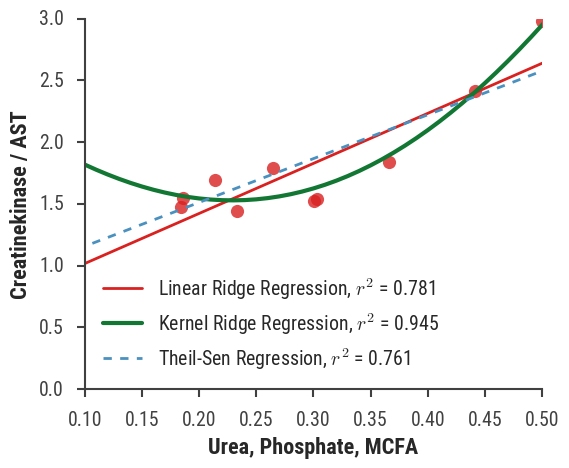

In [20]:
def visualize_marker(ms, tm, t):
    
    marker_type = t
    markers = ms
    target_marker_name = tm

    ids = []

    for n in markers:
        ids.append(np.where(bio_parameter_names == n)[0][0])

    target_data = bio_target_data[np.where(bio_target_names == target_marker_name)[0][0]]

    d = {}
    for i, (l, p) in enumerate(zip(st.ascii_letters[: len(ids)], bio_data1h[[ids]])):
        d[l] = p

    X = ne.evaluate(marker_type, d)
    X = sk_pr.normalize(X.reshape(-1, 1), axis=0)

    ridge = sk_lm.Ridge(alpha=0.001, normalize=False)
    ridge.fit(X, target_data)

    kr = sk_kr.KernelRidge(kernel='rbf', alpha=0.0001)
    kr.fit(X, target_data.reshape(-1, 1))

    ts = sk_lm.TheilSenRegressor()
    ts.fit(X, target_data)

    xmin = np.floor(np.min(X) / 0.1) * 0.1
    xmax = np.ceil(np.max(X) / 0.1) * 0.1

    f = plt.figure(figsize=(6, 5))

    flatui = ["#D92120", "#E6642C", "#117733", "#4B91C0", "#781C81"]
    sns.set_palette(sns.color_palette(flatui))

    g = sns.regplot(x='a', y='b', data={'a': X, 'b': target_data}, color=flatui[0], fit_reg=False,
                    scatter_kws={'s': 90})

    g.plot(np.arange(0, 1, 1/100)[:, None], ridge.predict(np.arange(0, 1, 1/100).reshape(-1, 1)),
            '-', label='Linear Ridge Regression, $r^2$ = %.3f' % ridge.score(X, target_data.reshape(-1, 1)),
            color=flatui[0], lw=2, zorder=1)

    g.plot(np.arange(0, 1, 1/100)[:, None], kr.predict(np.arange(0, 1, 1/100).reshape(-1, 1)),
            '-', label='Kernel Ridge Regression, $r^2$ = %.3f' % kr.score(X, target_data.reshape(-1, 1)),
            color=flatui[2], lw=3, zorder=1)

    g.plot(np.arange(0, 1, 1/100)[:, None], ts.predict(np.arange(0, 1, 1/100).reshape(-1, 1)),
            '--', label='Theil-Sen Regression, $r^2$ = %.3f' % ts.score(X, target_data.reshape(-1, 1)),
            color=flatui[3], lw=2, zorder=1)
    
    g.legend(loc='best')

    g.set(xlim=(xmin, xmax), ylim=(0, np.ceil(np.max(target_data))))

    g.set_xlabel(", ".join(markers), fontweight='bold')
    g.set_ylabel(target_marker_name, fontweight='bold')

    sns.despine()
    plt.tight_layout()

#visualize_marker(['Cholesterol', 'Phosphate', 'Chloride'], 'Creatinekinase / Albumin', 'a/b')
visualize_marker(['Urea', 'Phosphate', 'MCFA'], 'Creatinekinase / AST', 'a/b/c')

# 2 Physiological markers

## 2.1 Importing Data

In [21]:
# read pickle to pandas DataFrame
phys_df = pd.read_pickle('phys_db.pickle')

# biomarkers
phys_df['Biomarker'].count()

1732

## 2.2 Importing and Preprocessing Raw Data

In [22]:
# Parameter names
phys_csv_names = csv.reader(open('./PhysData/parameters-names.csv'), delimiter=';')
phys_parameter_names = np.array(list(phys_csv_names)).ravel()

# Setting shape of data array
phys_volunteers = 10
phys_parameters = 15
phys_points = 8

# Initializing data array with zeros
phys_data = np.zeros(shape=(phys_volunteers, phys_parameters, phys_points))

# Timepoints at which each biochemical parameter was measured (in hours after experiment)
# 0 stands for "before experiment", 0.05 - shortly after experiment, 1 - in an hour after experiment, so on...
phys_timepoints = np.array([0, 0.05, 1, 1*24, 2*24, 3*24, 5*24, 7*24, 9*24])

# Reading numeric data from csv-files
# Each file has a shape of N x M
#     where N is the number of parameters and M is the number of timepoints at which they were measured
for i in np.arange(phys_volunteers):
    phys_csv_file = csv.reader(open('./PhysData/%d.csv' % i), delimiter=';')
    phys_data[i, 0: phys_parameters + 1, 0: phys_points + 1] = np.array(list(phys_csv_file), np.float64)

# Mask zeros with NaN
phys_data[phys_data == 0] = np.nan

# Making an array of 1-hour measures
phys_data1h = phys_data[:,:,2].T
imp = sk_pr.Imputer(missing_values='NaN', strategy='mean')
phys_data1h = imp.fit_transform(phys_data1h)

# Shape
np.shape(phys_data1h)

(15, 10)

## 2.3 Results

In [23]:
len(phys_df.index)

1732

### 2.3.1 Combinatorial Markers with Highest Scores

In [24]:
phys_df.sort_values(by='Kernel Ridge Score', ascending=False)\
      .head(10)\
      .reset_index(drop=True)\
      [['Biomarker', 'Target marker', 'Kernel Ridge Score', 'Ridge Score', 'Theil-Sen Score']]

,Biomarker,Target marker,Kernel Ridge Score,Ridge Score,Theil-Sen Score
0,H-r Length*Isometric Strength/H-r Latency/SYS ...,Creatinekinase / AST,0.958987,0.080588,0.310636
1,H-r Length*Isometric Strength/H-r Latency/DIA ...,Creatinekinase / AST,0.953959,0.041325,0.167574
2,H-r Length*Contrac Tone/Isometric Strength/DIA...,Creatinekinase / AST,0.951667,0.745956,0.445460
3,H-r Latency*H-r Amplitude/H-r Length,Creatinekinase / AST,0.947877,0.116136,0.239893
4,R-Thigh Circ*Isometric Strength/H-r Latency/SY...,Creatinekinase / AST,0.945386,0.160472,0.333802
5,Isometric Strength*SYS Blood Pres 1/H-r Latenc...,Creatinekinase / AST,0.937174,0.108622,0.445756
6,H-r Latency*H-r Amplitude/H-r Length/R-Thigh Circ,Creatinekinase / AST,0.931010,0.117223,0.222082
7,Isometric Strength*DIA Blood Pres 1/H-r Latenc...,Creatinekinase / AST,0.930320,0.078162,0.413001
8,L-Thigh Circ*Isometric Strength/H-r Latency/SY...,Creatinekinase / AST,0.926256,0.181514,0.302188
9,H-r Length*Isometric Strength/H-r Latency/DIA ...,Creatinekinase / AST,0.922155,0.013483,0.324293


### 2.3.2 Combinatorial Markers Grouped by Type

In [25]:
# Showing top 3 in each group
for i, g in enumerate(phys_df.groupby('Type').groups.keys()):
    ipy.display(ipy.Markdown('### Combinatorial biomarkers of type _' + g + '_'))
    ipy.display(phys_df.groupby('Type')\
                .get_group(g)\
                .sort_values(by='Kernel Ridge Score', ascending=False)\
                .head(3)\
                .reset_index(drop=True))

### Combinatorial biomarkers of type _a/b/c_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,L-Thigh Circ/H-r Length/Isometric Strength,Creatinekinase / Myoglobin,L-Thigh Circ,H-r Length,Isometric Strength,NaN,4.138295,0.104085,0.909044,"7, 5, 10",4,a/b/c
1,H-r Latency/H-r Length/Isometric Strength,Creatinekinase / AST,H-r Latency,H-r Length,Isometric Strength,NaN,0.647433,0.375964,0.900641,"3, 5, 10",3,a/b/c
2,Contrac Tone/H-r Latency/Isometric Strength,Creatinekinase / AST,Contrac Tone,H-r Latency,Isometric Strength,NaN,0.619803,0.826668,0.877808,"9, 3, 10",3,a/b/c


### Combinatorial biomarkers of type _a*b/c_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,H-r Latency*H-r Amplitude/H-r Length,Creatinekinase / AST,H-r Latency,H-r Amplitude,H-r Length,NaN,0.239893,0.116136,0.947877,"3, 4, 5",3,a*b/c
1,H-r Length*Isometric Strength/DIA Blood Pres 2,Creatinekinase / AST,H-r Length,Isometric Strength,DIA Blood Pres 2,NaN,0.298406,0.131504,0.883814,"5, 10, 14",3,a*b/c
2,H-r Latency*L-Thigh Circ/Contrac Tone,AST,H-r Latency,L-Thigh Circ,Contrac Tone,NaN,1.046045,0.612786,0.752515,"3, 7, 9",1,a*b/c


### Combinatorial biomarkers of type _a/b_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,Isometric Strength/H-r Latency,Creatinekinase / AST,Isometric Strength,H-r Latency,NaN,NaN,0.355348,0.162076,0.908489,"10, 3",3,a/b
1,Contrac Tone/Isometric Strength,Creatinekinase / Albumin,Contrac Tone,Isometric Strength,NaN,NaN,1.002104,0.197496,0.717793,"9, 10",5,a/b
2,Contrac Tone/H-r Latency,Creatinekinase / Albumin,Contrac Tone,H-r Latency,NaN,NaN,1.270826,0.441696,0.635383,"9, 3",5,a/b


### Combinatorial biomarkers of type _1/a_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,1/Max Amp EMG,AST,Max Amp EMG,NaN,NaN,NaN,1.045355,0.229497,0.334895,0,1,1/a
1,1/H-r Length,Creatinekinase / Albumin,H-r Length,NaN,NaN,NaN,0.898667,0.011037,0.330339,5,5,1/a
2,1/DIA Blood Pres 2,Myoglobin / Albumin,DIA Blood Pres 2,NaN,NaN,NaN,1.164506,0.035757,0.155436,14,6,1/a


### Combinatorial biomarkers of type _a*b/c/d_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,H-r Length*Isometric Strength/H-r Latency/SYS ...,Creatinekinase / AST,H-r Length,Isometric Strength,H-r Latency,SYS Blood Pres 1,0.310636,0.080588,0.958987,"5, 10, 3, 11",3,a*b/c/d
1,H-r Length*Isometric Strength/H-r Latency/DIA ...,Creatinekinase / AST,H-r Length,Isometric Strength,H-r Latency,DIA Blood Pres 1,0.167574,0.041325,0.953959,"5, 10, 3, 12",3,a*b/c/d
2,H-r Length*Contrac Tone/Isometric Strength/DIA...,Creatinekinase / AST,H-r Length,Contrac Tone,Isometric Strength,DIA Blood Pres 2,0.445460,0.745956,0.951667,"5, 9, 10, 14",3,a*b/c/d


### Combinatorial biomarkers of type _a_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,SYS Blood Pres 1,Myoglobin / Albumin,SYS Blood Pres 1,NaN,NaN,NaN,0.962718,0.064495,0.148289,11,6,a
1,SYS Blood Pres 1,Myoglobin,SYS Blood Pres 1,NaN,NaN,NaN,1.023531,0.062679,0.148104,11,2,a


### 2.3.3 Combinatorial Markers Grouped by Target Markers

In [26]:
# Showing top 5 of each target marker
for i, g in enumerate(phys_df.groupby('Target marker').groups.keys()):
    ipy.display(ipy.Markdown('### Combinatorial biomarkers correlation with _' + g + '_'))
    ipy.display(phys_df.groupby('Target marker')\
                .get_group(g)\
                .sort_values(by='Kernel Ridge Score', ascending=False)\
                .head(5)\
                .reset_index(drop=True))

### Combinatorial biomarkers correlation with _AST_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,Contrac Tone/Isometric Strength/DIA Blood Pres 1,AST,Contrac Tone,Isometric Strength,DIA Blood Pres 1,NaN,2.965602,0.300484,0.792680,"9, 10, 12",1,a/b/c
1,Contrac Tone/L-Thigh Circ/Isometric Strength,AST,Contrac Tone,L-Thigh Circ,Isometric Strength,NaN,2.496793,0.328850,0.783257,"9, 7, 10",1,a/b/c
2,H-r Length*Contrac Tone/Mean Amp EMG/DIA Blood...,AST,H-r Length,Contrac Tone,Mean Amp EMG,DIA Blood Pres 1,5.638955,0.345033,0.780004,"5, 9, 1, 12",1,a*b/c/d
3,Isometric Strength*SYS Blood Pres 1/Contrac To...,AST,Isometric Strength,SYS Blood Pres 1,Contrac Tone,SYS Blood Pres 2,0.956173,0.615336,0.765334,"10, 11, 9, 13",1,a*b/c/d
4,H-r Latency*L-Thigh Circ/Contrac Tone,AST,H-r Latency,L-Thigh Circ,Contrac Tone,NaN,1.046045,0.612786,0.752515,"3, 7, 9",1,a*b/c


### Combinatorial biomarkers correlation with _Creatinekinase / AST_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,H-r Length*Isometric Strength/H-r Latency/SYS ...,Creatinekinase / AST,H-r Length,Isometric Strength,H-r Latency,SYS Blood Pres 1,0.310636,0.080588,0.958987,"5, 10, 3, 11",3,a*b/c/d
1,H-r Length*Isometric Strength/H-r Latency/DIA ...,Creatinekinase / AST,H-r Length,Isometric Strength,H-r Latency,DIA Blood Pres 1,0.167574,0.041325,0.953959,"5, 10, 3, 12",3,a*b/c/d
2,H-r Length*Contrac Tone/Isometric Strength/DIA...,Creatinekinase / AST,H-r Length,Contrac Tone,Isometric Strength,DIA Blood Pres 2,0.445460,0.745956,0.951667,"5, 9, 10, 14",3,a*b/c/d
3,H-r Latency*H-r Amplitude/H-r Length,Creatinekinase / AST,H-r Latency,H-r Amplitude,H-r Length,NaN,0.239893,0.116136,0.947877,"3, 4, 5",3,a*b/c
4,R-Thigh Circ*Isometric Strength/H-r Latency/SY...,Creatinekinase / AST,R-Thigh Circ,Isometric Strength,H-r Latency,SYS Blood Pres 1,0.333802,0.160472,0.945386,"6, 10, 3, 11",3,a*b/c/d


### Combinatorial biomarkers correlation with _Creatinekinase / Myoglobin_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,L-Thigh Circ/H-r Length/Isometric Strength,Creatinekinase / Myoglobin,L-Thigh Circ,H-r Length,Isometric Strength,NaN,4.138295,0.104085,0.909044,"7, 5, 10",4,a/b/c
1,Isometric Strength*DIA Blood Pres 2/H-r Length...,Creatinekinase / Myoglobin,Isometric Strength,DIA Blood Pres 2,H-r Length,Contrac Tone,1.425806,0.348194,0.823484,"10, 14, 5, 9",4,a*b/c/d
2,R-Thigh Circ/H-r Length/Isometric Strength,Creatinekinase / Myoglobin,R-Thigh Circ,H-r Length,Isometric Strength,NaN,4.969490,0.115246,0.822462,"6, 5, 10",4,a/b/c
3,H-r Latency*L-Thigh Circ/H-r Length/Isometric ...,Creatinekinase / Myoglobin,H-r Latency,L-Thigh Circ,H-r Length,Isometric Strength,2.688505,0.068055,0.798654,"3, 7, 5, 10",4,a*b/c/d
4,Isometric Strength/EMG Freq/L-Thigh Circ,Creatinekinase / Myoglobin,Isometric Strength,EMG Freq,L-Thigh Circ,NaN,2.886846,0.148997,0.796308,"10, 2, 7",4,a/b/c


### Combinatorial biomarkers correlation with _Myoglobin / Albumin_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,Relax Tone/L-Thigh Circ/Isometric Strength,Myoglobin / Albumin,Relax Tone,L-Thigh Circ,Isometric Strength,NaN,8.197722,0.223960,0.786178,"8, 7, 10",6,a/b/c
1,Contrac Tone/Isometric Strength/DIA Blood Pres 1,Myoglobin / Albumin,Contrac Tone,Isometric Strength,DIA Blood Pres 1,NaN,3.394315,0.340801,0.782525,"9, 10, 12",6,a/b/c
2,H-r Latency*Contrac Tone/R-Thigh Circ/L-Thigh ...,Myoglobin / Albumin,H-r Latency,Contrac Tone,R-Thigh Circ,L-Thigh Circ,1.270116,0.021174,0.764911,"3, 9, 6, 7",6,a*b/c/d
3,EMG Freq*Contrac Tone/Max Amp EMG/Isometric St...,Myoglobin / Albumin,EMG Freq,Contrac Tone,Max Amp EMG,Isometric Strength,0.874002,0.097253,0.748236,"2, 9, 0, 10",6,a*b/c/d
4,EMG Freq*Contrac Tone/L-Thigh Circ/Isometric S...,Myoglobin / Albumin,EMG Freq,Contrac Tone,L-Thigh Circ,Isometric Strength,0.919959,0.608670,0.742894,"2, 9, 7, 10",6,a*b/c/d


### Combinatorial biomarkers correlation with _Creatinekinase / Albumin_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,Contrac Tone/Isometric Strength/DIA Blood Pres 1,Creatinekinase / Albumin,Contrac Tone,Isometric Strength,DIA Blood Pres 1,NaN,5.416459,0.154376,0.861057,"9, 10, 12",5,a/b/c
1,Isometric Strength*DIA Blood Pres 1/Contrac To...,Creatinekinase / Albumin,Isometric Strength,DIA Blood Pres 1,Contrac Tone,SYS Blood Pres 1,1.202035,0.448035,0.845849,"10, 12, 9, 11",5,a*b/c/d
2,Contrac Tone*SYS Blood Pres 1/Isometric Streng...,Creatinekinase / Albumin,Contrac Tone,SYS Blood Pres 1,Isometric Strength,DIA Blood Pres 1,3.051005,0.177473,0.843264,"9, 11, 10, 12",5,a*b/c/d
3,R-Thigh Circ*Contrac Tone/Isometric Strength/D...,Creatinekinase / Albumin,R-Thigh Circ,Contrac Tone,Isometric Strength,DIA Blood Pres 1,4.048820,0.212711,0.834116,"6, 9, 10, 12",5,a*b/c/d
4,R-Thigh Circ*Contrac Tone/L-Thigh Circ/Isometr...,Creatinekinase / Albumin,R-Thigh Circ,Contrac Tone,L-Thigh Circ,Isometric Strength,1.754856,0.230994,0.802875,"6, 9, 7, 10",5,a*b/c/d


### Combinatorial biomarkers correlation with _Myoglobin_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,Relax Tone/L-Thigh Circ/Isometric Strength,Myoglobin,Relax Tone,L-Thigh Circ,Isometric Strength,NaN,8.183847,0.229092,0.771977,"8, 7, 10",2,a/b/c
1,H-r Latency*Contrac Tone/R-Thigh Circ/L-Thigh ...,Myoglobin,H-r Latency,Contrac Tone,R-Thigh Circ,L-Thigh Circ,1.181347,0.020823,0.766796,"3, 9, 6, 7",2,a*b/c/d
2,Contrac Tone/Isometric Strength/DIA Blood Pres 1,Myoglobin,Contrac Tone,Isometric Strength,DIA Blood Pres 1,NaN,3.240590,0.344308,0.766425,"9, 10, 12",2,a/b/c
3,EMG Freq*Contrac Tone/L-Thigh Circ/Isometric S...,Myoglobin,EMG Freq,Contrac Tone,L-Thigh Circ,Isometric Strength,0.895132,0.601358,0.739271,"2, 9, 7, 10",2,a*b/c/d
4,EMG Freq*Contrac Tone/Isometric Strength/DIA B...,Myoglobin,EMG Freq,Contrac Tone,Isometric Strength,DIA Blood Pres 1,1.599944,0.556678,0.727955,"2, 9, 10, 12",2,a*b/c/d


### Combinatorial biomarkers correlation with _Creatinekinase_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,Contrac Tone/Isometric Strength/DIA Blood Pres 1,Creatinekinase,Contrac Tone,Isometric Strength,DIA Blood Pres 1,NaN,6.104522,0.164588,0.860031,"9, 10, 12",0,a/b/c
1,Isometric Strength*DIA Blood Pres 1/Contrac To...,Creatinekinase,Isometric Strength,DIA Blood Pres 1,Contrac Tone,SYS Blood Pres 1,1.250784,0.457607,0.840238,"10, 12, 9, 11",0,a*b/c/d
2,Contrac Tone*SYS Blood Pres 1/Isometric Streng...,Creatinekinase,Contrac Tone,SYS Blood Pres 1,Isometric Strength,DIA Blood Pres 1,2.861637,0.187049,0.836264,"9, 11, 10, 12",0,a*b/c/d
3,R-Thigh Circ*Contrac Tone/Isometric Strength/D...,Creatinekinase,R-Thigh Circ,Contrac Tone,Isometric Strength,DIA Blood Pres 1,3.832636,0.221973,0.826551,"6, 9, 10, 12",0,a*b/c/d
4,R-Thigh Circ*Contrac Tone/L-Thigh Circ/Isometr...,Creatinekinase,R-Thigh Circ,Contrac Tone,L-Thigh Circ,Isometric Strength,1.635160,0.240481,0.791653,"6, 9, 7, 10",0,a*b/c/d


## 2.4 Statistics

### 2.4.1 Correlations Between Combinatorial Markers and Target Markers

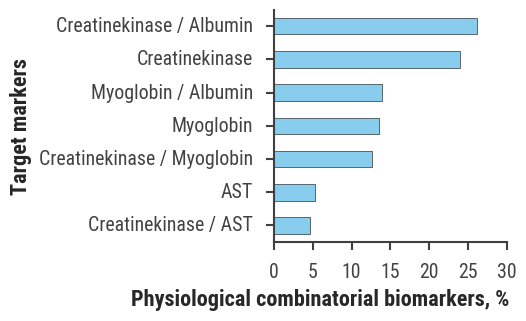

In [27]:
g = phys_df[['Target marker']].stack()\
                              .value_counts()\
                              .sort_values(ascending=True)\
                              .apply(lambda x: np.around(x / len(phys_df.index) * 100, 1))\
                              .plot(kind='barh', figsize=(3,3), color='#88CCEE')

g.set_ylabel('Target markers')
g.set_xlabel('Physiological combinatorial biomarkers, %', ha='center', position=(0.20, 0))

sns.despine()

In [28]:
phys_df[['Target marker']].stack()\
                          .value_counts()\
                          .sort_values(ascending=False)\
                          .apply(lambda x: np.around(x / len(phys_df.index) * 100, 1))

Creatinekinase / Albumin      26.2
Creatinekinase                24.0
Myoglobin / Albumin           13.9
Myoglobin                     13.5
Creatinekinase / Myoglobin    12.6
AST                            5.3
Creatinekinase / AST           4.6
dtype: float64

### 2.4.2 Occurence of Individual Markers in Combinatorial Markers

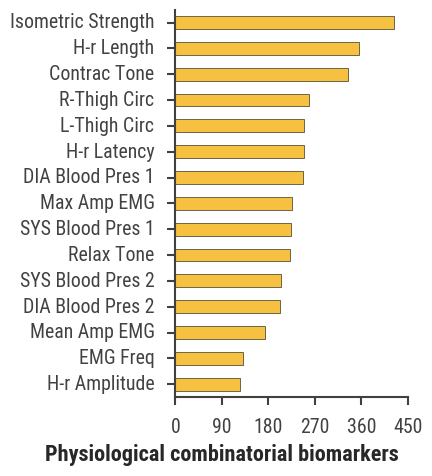

In [29]:
unique_markers = phys_df.drop_duplicates(subset='Biomarker').reset_index(drop=True)

g = unique_markers[['Marker 1', 'Marker 2', 'Marker 3', 'Marker 4']]\
            .stack()\
            .value_counts()\
            .sort_values(ascending=True)\
            .plot(kind='barh', figsize=(3, 5), xticks=np.arange(0, 460, 90), color='#F6C141')

g.set_xlabel('Physiological combinatorial biomarkers', ha='center', position=(0.20, 0))

sns.despine()

In [30]:
unique_markers = phys_df.drop_duplicates(subset='Biomarker').reset_index(drop=True)

g = unique_markers[['Marker 1', 'Marker 2', 'Marker 3', 'Marker 4']]\
            .stack()\
            .value_counts()\
            .apply(lambda x: str(np.around(x / len(unique_markers.index) * 100, 1)) + '%')
g

Isometric Strength    43.6%
H-r Length            36.7%
Contrac Tone          34.4%
R-Thigh Circ          26.7%
H-r Latency           25.6%
L-Thigh Circ          25.6%
DIA Blood Pres 1      25.4%
Max Amp EMG           23.3%
SYS Blood Pres 1      23.1%
Relax Tone            22.9%
SYS Blood Pres 2      21.2%
DIA Blood Pres 2      20.9%
Mean Amp EMG          17.9%
EMG Freq              13.5%
H-r Amplitude         12.9%
dtype: object

### 1.4.3 Physiological biomarkers and target markers: joint sets

In [31]:
q = phys_df.groupby(('Biomarker'))\
      .agg({'Target marker': 'count', 'Kernel Ridge Score': 'mean', 'Theil-Sen Score': 'mean', 'Ridge Score': 'mean'})\
      .sort_values(['Target marker', 'Kernel Ridge Score'], ascending=False)

ipy.display(ipy.Markdown('#### Markers strongly correlated with three or more targets'),
            len(q[q['Target marker'] >= 3].index))

ipy.display(ipy.Markdown('#### Unique combinatorial markers'),
            len(q.index),
            ipy.HTML(
                        q.head(10)\
                          [['Target marker', 'Kernel Ridge Score', 'Ridge Score', 'Theil-Sen Score']]
                          .reset_index()\
                          .to_html()
))

#### Markers strongly correlated with three or more targets

151

#### Unique combinatorial markers

968

,Biomarker,Target marker,Kernel Ridge Score,Ridge Score,Theil-Sen Score
0,H-r Length*Contrac Tone/Max Amp EMG/Mean Amp EMG,6,0.484344,0.199650,2.468996
1,H-r Length*Contrac Tone/Max Amp EMG/L-Thigh Circ,6,0.467022,0.218022,1.281292
2,R-Thigh Circ*DIA Blood Pres 2/Contrac Tone/SYS...,6,0.464185,0.369479,0.989356
3,H-r Length/Max Amp EMG,6,0.259930,0.163553,1.041286
4,H-r Length/Max Amp EMG/R-Thigh Circ,6,0.243247,0.162328,2.026401
5,Contrac Tone/Isometric Strength/DIA Blood Pres 1,5,0.812543,0.260911,4.224298
6,R-Thigh Circ*Contrac Tone/Isometric Strength/D...,5,0.752616,0.306047,2.361174
7,Contrac Tone/L-Thigh Circ/Isometric Strength,5,0.723886,0.266356,2.410329
8,Contrac Tone/Max Amp EMG/Isometric Strength,5,0.699804,0.282086,1.985587
9,H-r Length*Contrac Tone/Mean Amp EMG/DIA Blood...,5,0.661110,0.184189,5.337367


#### Export to Excel

In [32]:
writer = pd.ExcelWriter('Results/combinatorial_physiological_markers_top_10_joint.xlsx', engine='xlsxwriter')

phys_df.groupby(('Biomarker'))\
      .agg({'Target marker': 'count', 'Kernel Ridge Score': 'mean', 'Theil-Sen Score': 'mean', 'Ridge Score': 'mean'})\
      .sort_values(['Target marker', 'Kernel Ridge Score'], ascending=False)\
      .head(10)\
      [['Target marker', 'Kernel Ridge Score', 'Ridge Score', 'Theil-Sen Score']]\
      .reset_index()\
      .to_excel(writer, sheet_name='Markers')


writer.save()

## 2.5 Cross-Validation

In [33]:
def cv_iter(num):

    phys_cv_dict = {'Biomarker': [], 'Target marker': [], 'Type': [],
                   'MAPE': [], 'MAD': [], 'MSE': [], 'RMSE': []}

    for btn, i in itertools.product(bio_target_names, np.arange(num)):

        params = phys_df.groupby('Target marker')\
                   .get_group(btn)\
                   .sort_values(by='Kernel Ridge Score', ascending=False)\
                   .reset_index(drop=True)\
                   .loc[i]['MID']\
                   .split(', ')
        group = phys_df.groupby('Target marker')\
                   .get_group(btn)\
                   .sort_values(by='Kernel Ridge Score', ascending=False)\
                   .reset_index(drop=True)\
                   .loc[i]['Type']

        name = phys_df.groupby('Target marker')\
                   .get_group(btn)\
                   .sort_values(by='Kernel Ridge Score', ascending=False)\
                   .reset_index(drop=True)\
                   .loc[i]['Biomarker']

        target_data = bio_target_data[np.where(bio_target_names == btn)[0][0]]

        params = list(map(int, params))

        d = {}
        for i, (l, p) in enumerate(zip(st.ascii_letters[: len(params)], phys_data1h[[params]])):
            d[l] = p

        X = ne.evaluate(group, d)
        X = sk_pr.normalize(X.reshape(-1, 1), axis=0)

        ridge = sk_lm.Ridge(alpha=0.001, normalize=False)
        ridge.fit(X, target_data)

        kr = sk_kr.KernelRidge(kernel='rbf', alpha=0.0001)
        kr.fit(X, target_data.reshape(-1, 1))

        # Cross-Validation
        MAPE_scores = np.array([])
        MAD_scores = np.array([])
        MSE_scores = np.array([])
        RMSE_scores = np.array([])

        kf = sk_cv.KFold(n_splits=10, random_state=9)

        for train_index, test_index in kf.split(X):

            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = target_data[train_index], target_data[test_index]

            kr_cv = sk_kr.KernelRidge(kernel='rbf', alpha=0.0001).fit(X_train, y_train)
            y_pred = kr_cv.predict(X_test)

            MAPE = np.sum(np.abs((y_test - y_pred)) / y_test * 100) / 2
            MAD = np.sum(np.abs(y_test - y_pred)) / 2
            MSE = np.sum(np.abs(y_test - y_pred)**2) / 2
            RMSE = np.sqrt(MSE)

            MAPE_scores = np.append(MAPE_scores, MAPE)
            MAD_scores = np.append(MAD_scores, MAD)
            MSE_scores = np.append(MSE_scores, MSE)
            RMSE_scores = np.append(RMSE_scores, RMSE)

        phys_cv_dict['Biomarker'].append(name)
        phys_cv_dict['Target marker'].append(btn)
        phys_cv_dict['Type'].append(group)

        phys_cv_dict['MAPE'].append(MAPE_scores.mean())
        phys_cv_dict['MAD'].append(MAD_scores.mean())
        phys_cv_dict['MSE'].append(MSE_scores.mean())
        phys_cv_dict['RMSE'].append(RMSE_scores.mean())

    return phys_cv_dict

# initialize ExcelWriter
writer = pd.ExcelWriter('Results/combinatorial_physiological_markers_cv_results.xlsx', engine='xlsxwriter')

# convert the dataframe to an XlsxWriter Excel object
df10 = cv_iter(10)
phys_cv_df_10 = pd.DataFrame(df10, index=np.arange(len(bio_target_names) * 10))
phys_cv_df_10.sort_values(by='MAPE').reset_index(drop=True).head(10).to_excel(writer, sheet_name='Overall')

# convert the dataframe to an XlsxWriter Excel object
phys_cv_df_1 = pd.DataFrame(cv_iter(1), index=np.arange(len(bio_target_names) * 1))
phys_cv_df_1.sort_values(by='MAPE').reset_index(drop=True).head(10).to_excel(writer, sheet_name='Top 1 by Target')

# save an Excel file
writer.save()

# 3 Publication Figures

## Figure 2

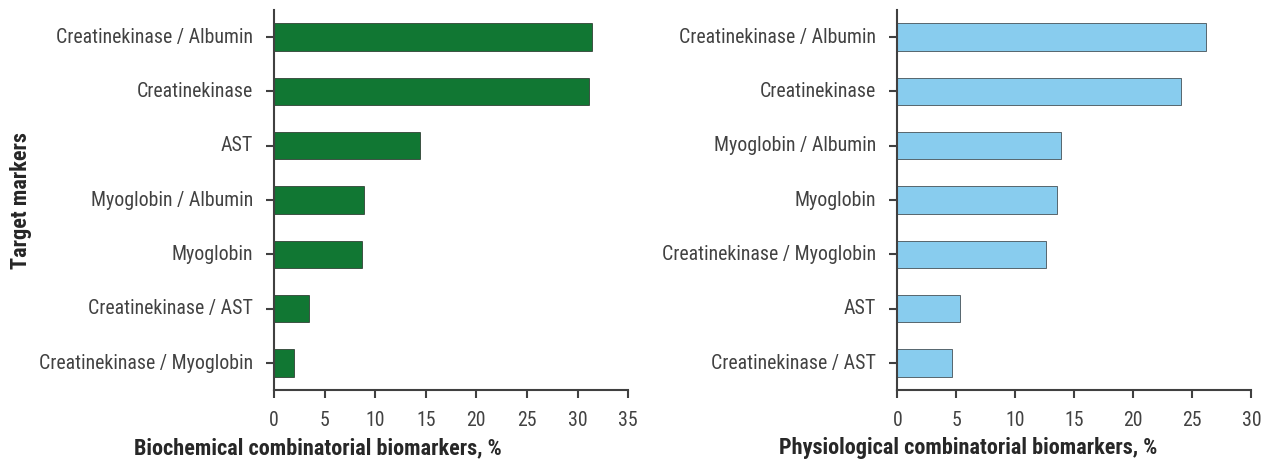

In [34]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, sharex=False)
f.set_figheight(5)
f.set_figwidth(13)

g = bio_df[['Target marker']].stack()\
                             .value_counts()\
                             .sort_values(ascending=True)\
                             .apply(lambda x: np.around(x / bio_df['Biomarker'].count() * 100, 1))\
                             .plot(kind='barh', ax=ax1, color='#117733')

g.set_ylabel('Target markers')
g.set_xlabel('Biochemical combinatorial biomarkers, %', ha='center', position=(0.125, 0))

g2 = phys_df[['Target marker']].stack()\
                             .value_counts()\
                             .sort_values(ascending=True)\
                             .apply(lambda x: np.around(x / len(phys_df.index) * 100, 1))\
                             .plot(kind='barh', ax=ax2, color='#88CCEE')

g2.set_ylabel('')
g2.set_xlabel('Physiological combinatorial biomarkers, %', ha='center', position=(0.20, 0))
sns.despine()
f.tight_layout()
f.savefig('Results/figure 2.eps', format="eps")

## Figure 3

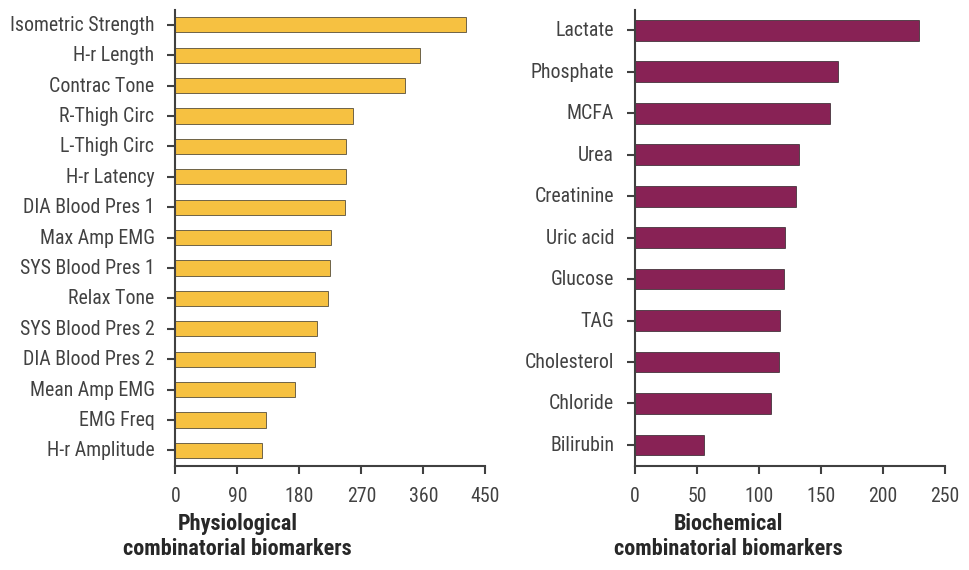

In [35]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, sharex=False)
f.set_figheight(6)
f.set_figwidth(10)

# Physiological
unique_phys_markers = phys_df.drop_duplicates(subset='Biomarker').reset_index(drop=True)
g = unique_phys_markers[['Marker 1', 'Marker 2', 'Marker 3', 'Marker 4']]\
            .stack()\
            .value_counts()\
            .sort_values(ascending=True)\
            .plot(kind='barh', ax=ax1, xticks=np.arange(0, 460, 90), color='#F6C141')
g.set_xlabel('Physiological\ncombinatorial biomarkers', ha='center', position=(0.20, 0))

# Biochemical
unique_biochem_markers = bio_df.drop_duplicates(subset='Biomarker').reset_index(drop=True)
g2 = unique_biochem_markers[['Marker 1', 'Marker 2', 'Marker 3', 'Marker 4']]\
            .stack()\
            .value_counts()\
            .sort_values(ascending=True)\
            .plot(kind='barh', ax=ax2, color='#882255')

g2.set_xlabel('Biochemical\ncombinatorial biomarkers', ha='center', position=(0.30, 0))

# Figure saving
sns.despine()
f.tight_layout()
f.savefig('Results/figure 3.eps', format="eps")